# Mean Squared OLS Forecast Error

**Julien Pascal**

This notebook illustrates the mean squared error integration error (MSIE) formula in a simplified setting, in which the true model for the conditional variance is a linear model:  $E_t = \boldsymbol{s}_m' \boldsymbol{\theta^{*}}$.  

The MSIE is given by:

\begin{equation}
    E\Big[\big(\boldsymbol{s}_m' \boldsymbol{\theta^{*}} - \boldsymbol{s}_m' \boldsymbol{\theta}^{(n)}\big)^{2} \Big] = \frac{\sigma_{g,\varepsilon}^2 k}{N^{\alpha}(M-k-1)}, \quad \text{for } M > k+1
\end{equation}

where $\sigma_{g,\varepsilon}^2 \equiv Var_{\varepsilon}(g(\boldsymbol{s}_m, \boldsymbol{\varepsilon}|\boldsymbol{\theta}^{(n)}))$ is the variance of the simulated target coming from the innovation vector $\boldsymbol{\varepsilon}$, while $k$ denotes the dimension of the vector $\boldsymbol{\theta}^{(n)}$, which constitutes our current best guess for $\boldsymbol{\theta^{*}}$.

The parameter $\alpha > 0$ depends on the method used for sampling the innovation vector and on the economic problem under consideration. A parameter value of $\alpha=1$ corresponds to a convergence rate of $O(1/\sqrt{N})$ for the integration error with respect to the innovation vector $\boldsymbol{\varepsilon}$, which is the usual convergence rate for Monte Carlo integration with random sampling. If randomized low-discrepancy sequences are instead used, such as randomized Halton or Sobol sequences, a value $\alpha > 1$ is usually expected. Indeed, in practical applications, low-discrepancy sequences lead to integration errors that converge at a rate close to $O(1/N)$.

In this notebook, the "model" is $E_t = \boldsymbol{s}_m' \boldsymbol{\theta^{*}}$.  
The code proceeds as follows:
* Draw a state vector $s_m$ from $N(0, S_x)$.
* Simulate $s_m'\theta^{*} + e$, using the true value for the parameter vector and random sampling for $e$.
* Estimate $\theta^{(n)}$ by OLS.
* Draw a new state vector $\tilde{s}_m$ from $N(0, S_x)$.
* Calculate MSIE $\tilde{s}_m'(\theta^{*} - \theta^{(n)})^2$.

Note that the formula above implies that:

$\log(MSIE) = \log(\sigma_{g,\varepsilon}^2) + \log(k) - \alpha \log(N) - \log(M-k-1)$

which can be estimated using a simple linear model:

$\log(MSIE) = \gamma_0 + \gamma_1 \log(k) + \gamma_2 \log(N) + \gamma_3 \log(M-k-1) + \varepsilon$.

Thus, after a linear regression, one should expect:
* $\gamma_1 = 1$
* $\gamma_2 = \alpha$, with $\alpha \approx 1$ when using random sampling, or $\alpha \approx 2$ when using randomized low-discrepancy sequences
* $\gamma_3 = -1$


In [1]:
import numpy as np
from scipy.linalg import toeplitz
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.stats import qmc 
import cpuinfo

## I. Random sampling for the innovation vector 


In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Define parameter ranges for simulation
k_list = [2, 5, 10]        # Different dimensions for the state vector
M_list = [100, 200, 300, 1000, 10000]   # Different training sample sizes
N_list = [1, 5, 10, 50, 100, 1000]     # Different number of innovation draws per state
L = 10                 # Number of replications for each setting
sigma_e = 1.0           # Standard deviation of the error term
M_test = 1000           # Number of test observations for forecast error calculation

results = []  # To store simulation results

for k in k_list:
    # Define S_x as a diagonal covariance matrix with increasing variances, e.g. diag(1,2,...,k)
    diag_vals = np.arange(1, k+1)
    S_x = np.diag(diag_vals)
    # True coefficient vector
    b_true = np.arange(k) #np.ones(k)
    
    # For each combination of M and N
    for M in M_list:
        for N in N_list:
            # Ensure M > k+1 to satisfy theoretical condition
            if M <= k + 1:
                continue

            forecast_errors = []
            for rep in range(L):
                # --- Step 1: Generate training data ---
                # Generate M states: s_m ~ N(0, S_x)
                # Since S_x is diagonal, we can sample each dimension as N(0, sqrt(variance))
                X = np.random.randn(M, k) * np.sqrt(diag_vals)
                
                # For each state, generate N independent error terms: e ~ N(0, sigma_e^2)
                E = np.random.randn(M, N) * sigma_e  # shape: (M, N)
                
                # Compute simulated dependent variable: y_m|s_m = s_m' b_true + average error
                y = X.dot(b_true) + np.mean(E, axis=1)
                
                # --- Step 2: Run OLS regression of y on s_m ---
                # Compute the OLS estimator b_hat
                b_hat, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
                
                # --- Step 3: Compute forecast error on a new test sample ---
                # Generate new test states from N(0, S_x)
                X_test = np.random.randn(M_test, k) * np.sqrt(diag_vals)
                # Forecast error for each test observation: (s_test'*(b_true - b_hat))
                errors = X_test.dot(b_true - b_hat)
                # Mean square forecast error for this replication
                mse = np.mean(errors**2)
                forecast_errors.append(mse)
            
            # Average empirical forecast error over L replications
            emp_mse = np.mean(forecast_errors)
            # Theoretical forecast error as given in the paper:
            th_mse = sigma_e**2 * k / (N * (M - k - 1))
            
            # Store the results in a dictionary
            results.append({
                "k": k,
                "M": M,
                "N": N,
                "empirical_mse": emp_mse,
                "theoretical_mse": th_mse
            })

# Create a Pandas DataFrame from the results
df_results = pd.DataFrame(results)
print(df_results)


     k      M     N  empirical_mse  theoretical_mse
0    2    100     1   3.099862e-02         0.020619
1    2    100     5   3.703599e-03         0.004124
2    2    100    10   2.663896e-03         0.002062
3    2    100    50   3.517634e-04         0.000412
4    2    100   100   2.456002e-04         0.000206
..  ..    ...   ...            ...              ...
85  10  10000     5   2.303835e-04         0.000200
86  10  10000    10   1.179112e-04         0.000100
87  10  10000    50   2.081108e-05         0.000020
88  10  10000   100   9.352717e-06         0.000010
89  10  10000  1000   9.373681e-07         0.000001

[90 rows x 5 columns]


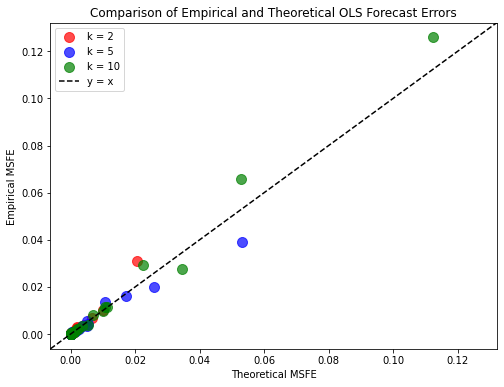

In [3]:
# --- Plotting ---
# Scatter plot: x-axis = theoretical forecast error, y-axis = empirical forecast error.
# Color-code by k for clarity.
fig, ax = plt.subplots(figsize=(8, 6))

colors = {2: 'red', 5: 'blue', 10: 'green'}
for k_val, group in df_results.groupby("k"):
    ax.scatter(group["theoretical_mse"], group["empirical_mse"], color=colors[k_val], s=100, alpha=0.7, label=f"k = {k_val}")

# Plot the 45° reference line (y=x)
lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, ls="--", c="black", label="y = x")
ax.set_xlim(lims)
ax.set_ylim(lims)

ax.set_xlabel("Theoretical MSFE")
ax.set_ylabel("Empirical MSFE")
ax.set_title("Comparison of Empirical and Theoretical OLS Forecast Errors")
ax.legend()
plt.show()


In [4]:
m = smf.ols("np.log(empirical_mse) ~ np.log(k) + np.log(N) + np.log(M - k - 1)", data=df_results).fit()
# sigma_e**2 * k / (N**alpha * (M - k - 1))
# with alpha=1 (random sampling)
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     np.log(empirical_mse)   R-squared:                       0.994
Model:                               OLS   Adj. R-squared:                  0.993
Method:                    Least Squares   F-statistic:                     4443.
Date:                   Tue, 06 May 2025   Prob (F-statistic):           3.71e-94
Time:                           13:11:27   Log-Likelihood:                 4.7057
No. Observations:                     90   AIC:                            -1.411
Df Residuals:                         86   BIC:                             8.588
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0044      0.120      0.036      0.971      -0.235       0.243
np.log(k)             0.9997      0.038     26.609      0.000       0.925       1.074
np.log(N)            -1.0061      0.011    -90.547      0.000      -1.028      -0.984
np.log(M - k - 1)    -1.0027      0.015    -66.278      0.000      -1.033      -0.973
==============================================================================
Omnibus:                        0.383   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.826   Jarque-Bera (JB):                0.123
Skew:                          -0.077   Prob(JB):                        0.940
Kurtosis:                       3.097   Cond. No.                         37.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## II. Randomized random sampling for the innovation vector

Randomized Sobol sequence, instead of random sampling.

In [5]:
# Set random seed for reproducibility
np.random.seed(42)

# Define parameter ranges for simulation
k_list = [2, 5, 10]        # Different dimensions for the state vector
M_list = [100, 200, 300, 1000, 10000]  # Different training sample sizes
N_list = [1, 2, 4, 8, 16, 32, 64, 128, 2*128, 4*128] #[1, 2**2, 2**4, 2**6]     # Different number of innovation draws per state
L = 10                 # Number of replications for each setting
sigma_e = 1.0           # Standard deviation of the error term
M_test = 1000           # Number of test observations for forecast error calculation
alpha = 2.0               # For Sobol low-discrepancy sampling (O(1/n) integration error)

results = []  # To store simulation results
sampler = qmc.MultivariateNormalQMC(mean=[0], cov=[[sigma_e**2]])

for k in k_list:
    # Define S_x as a diagonal covariance matrix with increasing variances, e.g. diag(1,2,...,k)
    diag_vals = np.arange(1, k+1)
    S_x = np.diag(diag_vals)
    
    # True coefficient vector:
    b_true = np.arange(k)
    
    # For each combination of M and N
    for M in M_list:
        for N in N_list:
            # Ensure M > k+1 to satisfy the condition for the theoretical formula
            if M <= k + 1:
                continue

            forecast_errors = []
            for rep in range(L):
                # --- Step 1: Generate training data ---
                # Generate M states: s_m ~ N(0, S_x)
                # Since S_x is diagonal, each dimension is scaled by sqrt(diag value)
                X = np.random.randn(M, k) * np.sqrt(diag_vals)
                
                # --- Step 2: Generate innovations using randomized Sobol ---
                # Create a Sobol-based sampler for a univariate normal distribution N(0, sigma_e^2)
                # Generate M*N samples and reshape them into an (M, N) matrix
                E = sampler.random(M * N).reshape(M, N)
                
                # Compute simulated dependent variable: y_m|s_m = s_m' * b_true + (average error)
                y = X.dot(b_true) + np.mean(E, axis=1)
                
                # --- Step 3: Run OLS regression of y on s_m ---
                b_hat, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
                
                # --- Step 4: Compute forecast error on a new test sample ---
                X_test = np.random.randn(M_test, k) * np.sqrt(diag_vals)
                
                # Forecast error: (s_test'*(b_true - b_hat))
                errors = X_test.dot(b_true - b_hat)
                mse = np.mean(errors**2)
                forecast_errors.append(mse)
            
            # Average empirical forecast error over L replications
            emp_mse = np.mean(forecast_errors)
            # Theoretical forecast error using Sobol (alpha=2):
            th_mse = sigma_e**2 * k / (N**alpha * (M - k - 1))
            
            # Store the results in a dictionary
            results.append({
                "k": k,
                "M": M,
                "N": N,
                "empirical_mse": emp_mse,
                "theoretical_mse": th_mse
            })

# Create a Pandas DataFrame from the results
df_results = pd.DataFrame(results)
print(df_results)

/home/julien/.local/lib/python3.8/site-packages/scipy/stats/_qmc.py:763: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


      k      M    N  empirical_mse  theoretical_mse
0     2    100    1   1.910819e-02     2.061856e-02
1     2    100    2   2.567378e-03     5.154639e-03
2     2    100    4   3.374553e-04     1.288660e-03
3     2    100    8   8.236199e-06     3.221649e-04
4     2    100   16   3.331616e-06     8.054124e-05
..   ..    ...  ...            ...              ...
145  10  10000   32   7.220837e-08     9.776379e-07
146  10  10000   64   1.955586e-08     2.444095e-07
147  10  10000  128   1.401919e-08     6.110237e-08
148  10  10000  256   6.894297e-09     1.527559e-08
149  10  10000  512   5.962405e-09     3.818898e-09

[150 rows x 5 columns]


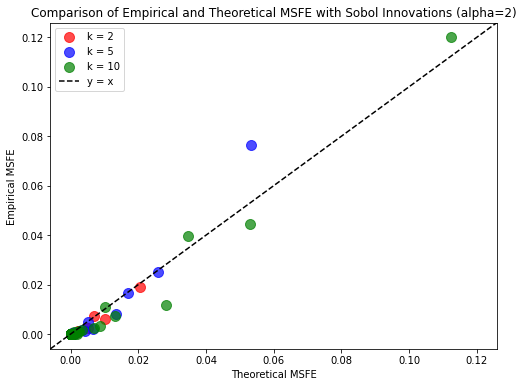

In [6]:
# --- Plotting ---
# Scatter plot: x-axis = theoretical forecast error, y-axis = empirical forecast error.
# Color-code by k for clarity.
fig, ax = plt.subplots(figsize=(8, 6))

colors = {2: 'red', 5: 'blue', 10: 'green'}
for k_val, group in df_results.groupby("k"):
    ax.scatter(group["theoretical_mse"], group["empirical_mse"], 
               color=colors[k_val], s=100, alpha=0.7, label=f"k = {k_val}")

# Plot the 45° reference line (y=x)
lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, ls="--", c="black", label="y = x")
ax.set_xlim(lims)
ax.set_ylim(lims)

ax.set_xlabel("Theoretical MSFE")
ax.set_ylabel("Empirical MSFE")
ax.set_title("Comparison of Empirical and Theoretical MSFE with Sobol Innovations (alpha=2)")
ax.legend()
plt.show()

In [7]:
m = smf.ols("np.log(empirical_mse) ~ np.log(k) + np.log(N) + np.log(M - k - 1)", data=df_results).fit()
# sigma_e**2 * k / (N**alpha * (M - k - 1))
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     np.log(empirical_mse)   R-squared:                       0.929
Model:                               OLS   Adj. R-squared:                  0.928
Method:                    Least Squares   F-statistic:                     637.0
Date:                   Tue, 06 May 2025   Prob (F-statistic):           1.26e-83
Time:                           13:11:55   Log-Likelihood:                -240.57
No. Observations:                    150   AIC:                             489.1
Df Residuals:                        146   BIC:                             501.2
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.7488      0.487     -3.591      0.000      -2.711      -0.786
np.log(k)             0.9921      0.151      6.568      0.000       0.694       1.291
np.log(N)            -2.0071      0.050    -40.133      0.000      -2.106      -1.908
np.log(M - k - 1)    -0.9724      0.061    -15.986      0.000      -1.093      -0.852
==============================================================================
Omnibus:                       18.401   Durbin-Watson:                   0.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                6.306
Skew:                          -0.189   Prob(JB):                       0.0427
Kurtosis:                       2.069   Cond. No.                         37.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
!python3 --version

Python 3.8.10


In [9]:
cpuinfo.get_cpu_info()

{'python_version': '3.8.10.final.0 (64 bit)',
 'cpuinfo_version': [9, 0, 0],
 'cpuinfo_version_string': '9.0.0',
 'arch': 'X86_64',
 'bits': 64,
 'count': 12,
 'arch_string_raw': 'x86_64',
 'vendor_id_raw': 'GenuineIntel',
 'brand_raw': 'Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz',
 'hz_advertised_friendly': '2.6000 GHz',
 'hz_actual_friendly': '1.2292 GHz',
 'hz_advertised': [2600000000, 0],
 'hz_actual': [1229194000, 0],
 'stepping': 10,
 'model': 158,
 'family': 6,
 'flags': ['3dnowprefetch',
  'abm',
  'acpi',
  'adx',
  'aes',
  'aperfmperf',
  'apic',
  'arat',
  'arch_capabilities',
  'arch_perfmon',
  'art',
  'avx',
  'avx2',
  'bmi1',
  'bmi2',
  'bts',
  'clflush',
  'clflushopt',
  'cmov',
  'constant_tsc',
  'cpuid',
  'cpuid_fault',
  'cx16',
  'cx8',
  'de',
  'ds_cpl',
  'dtes64',
  'dtherm',
  'dts',
  'epb',
  'ept',
  'ept_ad',
  'erms',
  'est',
  'f16c',
  'flexpriority',
  'flush_l1d',
  'fma',
  'fpu',
  'fsgsbase',
  'fxsr',
  'hle',
  'ht',
  'hwp',
  'hwp_act_wi